# ARIMA - Ice Cream Production


## Install and import libraries
---
This exercise requires the `pdarima` library, which can be installed with Python's `pip` command. This command only needs to be done once per machine.


The standard, shorter approach may work:

In [1]:
# pip install pmdarima --user

If the above command didn't work, it may be necessary to be more explicit, in which case you could run the code below.

In [2]:
# import sys
# !{sys.executable} -m pip install pmdarima --user

Once `pdarima` is installed, then load the libraries below.

In [3]:
import pandas as pd
import numpy as np
from scipy import stats                                 # needed for z-score
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima

## Load and prepare data
---

In [4]:
df = pd.read_csv('../datasets/icecreamproduction.csv', parse_dates=['Month'], index_col=['Month'])


## Plot data
---

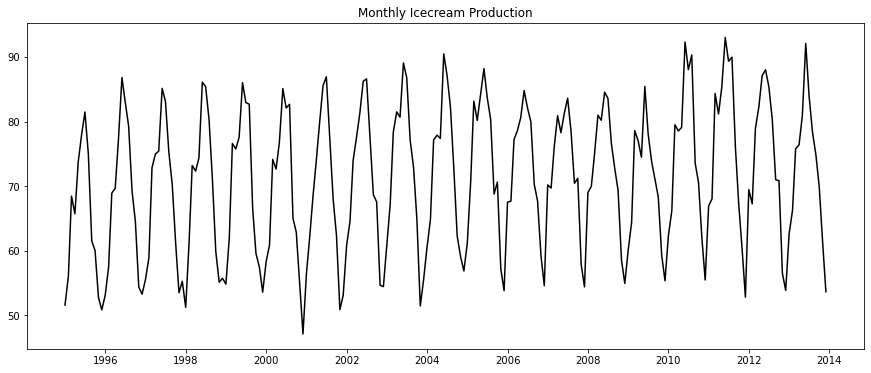

In [5]:
fig, ax = plt.subplots(figsize=(15, 6))
x = df.index
y = df['Icecream.Prod']
plt.plot(x, y, color='black')

plt.title('Monthly Icecream Production')

# Format the x-axis ticks as years
date_form = DateFormatter("%Y")


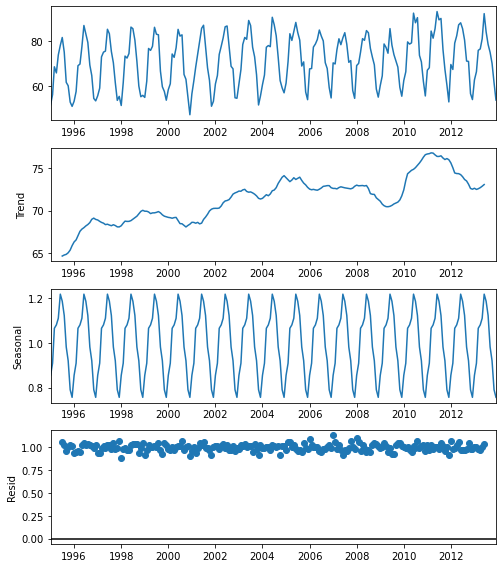

In [8]:
plt.rcParams['figure.figsize'] = [7, 8]
sd = seasonal_decompose(df, period=12, model ='multiplacative').plot()


## Split data into train and test set
---

### Create Training Dataset

In [9]:
# Select data from before 2011.

train = df.loc[df.index < '2011-01-01']


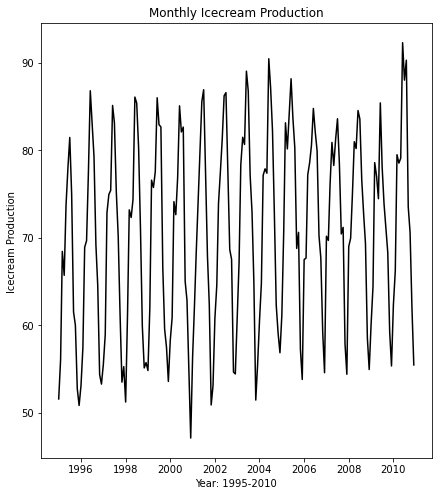

In [10]:
# Plot the training data

fig, ax = plt.subplots()
plt.xlabel('Year: 1995-2010')
plt.ylabel('Icecream Production ')
plt.title('Monthly Icecream Production')
plt.plot(train, color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

### Create Testing Dataset

In [11]:
# Use data from 1958 through 1960 (the last three years) for testing.

test = df.loc[df.index >= '2011-01-01']

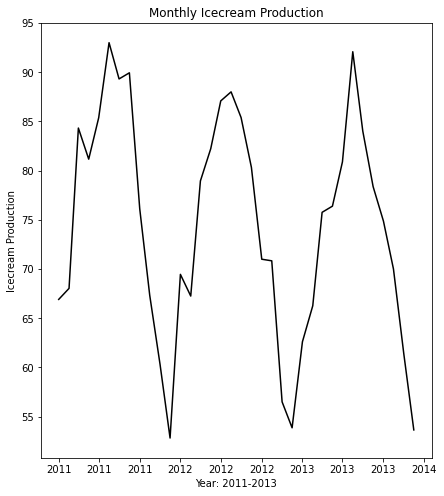

In [12]:
# Plot the testing data.
# Note that the vertical scale changes from the previous graph.

fig, ax = plt.subplots()
plt.xlabel('Year: 2011-2013')
plt.ylabel('Icecream Production')
plt.title('Monthly Icecream Production')
plt.plot(test, color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

## Prepare the model
---

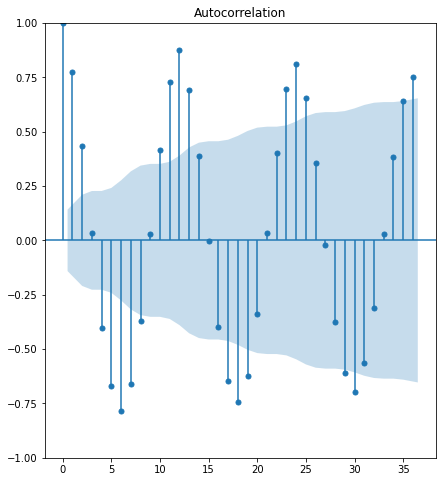

In [15]:
# Test Stationarity
train_acf = plot_acf(train, lags=36)

### Linear Model

In [16]:
lr = sm.OLS(endog=train['Icecream.Prod'], exog=sm.add_constant(np.arange(1, 1 + train.shape[0]))).fit() 
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:          Icecream.Prod   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     6.739
Date:                Wed, 26 Apr 2023   Prob (F-statistic):             0.0102
Time:                        15:40:45   Log-Likelihood:                -728.86
No. Observations:                 192   AIC:                             1462.
Df Residuals:                     190   BIC:                             1468.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         67.0740      1.570     42.735      0.0

In [17]:
# Extract the fitted values.
y_hat = lr.fittedvalues

In [18]:
# Extract the 95% prediction interval.
y_ci = lr.get_prediction().conf_int(alpha=0.05)

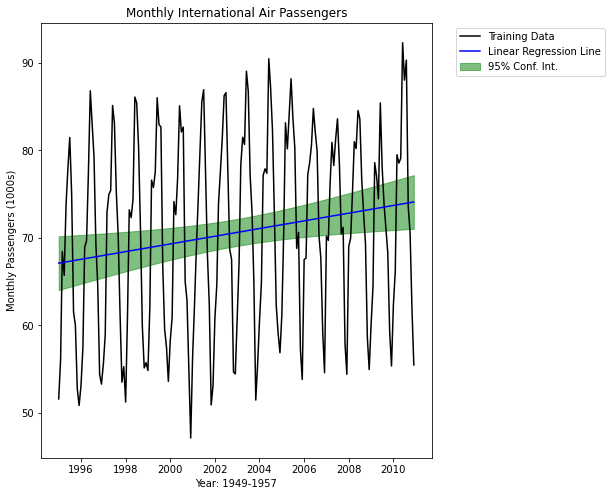

In [19]:
# Graph time series with linear regression line and corresponding 95% confidence interval.
fig, ax = plt.subplots()
plt.xlabel('Year: 1949-1957')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly International Air Passengers')
plt.plot(train, color='black', label='Training Data')
plt.plot(y_hat, color='blue', label='Linear Regression Line')
plt.fill_between(y_hat.index, y_ci[:, 0], y_ci[:, 1], color='green', alpha=0.5, label='95% Conf. Int.')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

## ARIMA: Train model
---

In [20]:
auto_arima_model = auto_arima(train, m=12, with_intercept=False, suppress_warnings=True)
print(auto_arima_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  192
Model:             SARIMAX(2, 0, 2)x(1, 0, 2, 12)   Log Likelihood                -488.092
Date:                            Wed, 26 Apr 2023   AIC                            992.184
Time:                                    15:41:53   BIC                           1018.244
Sample:                                01-01-1995   HQIC                          1002.738
                                     - 12-01-2010                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2364      0.068      3.473      0.001       0.103       0.370
ar.L2          0.7405      0.066   

In [21]:
# Extract the residuals. 
resid = auto_arima_model.resid()

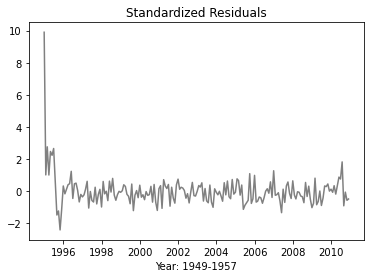

In [125]:
# Plot the standardized residuals.
fig, ax = plt.subplots()
plt.plot(train.index, stats.zscore(resid), color='gray') 
plt.title('Standardized Residuals')
plt.xlabel('Year: 1949-1957')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

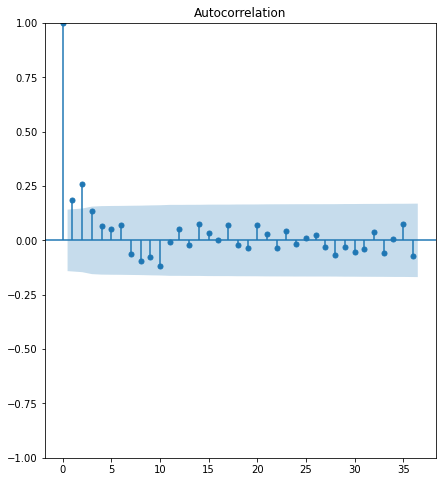

In [24]:
# Plot the ACF (autocorrelation function) of the residuals. 
res_acf = plot_acf(resid, lags=36)

## Test the model
---

In [25]:
# Fit the best model to the training data.
auto_arima_model.fit(train)

ARIMA(order=(2, 0, 2), scoring_args={}, seasonal_order=(1, 0, 2, 12),
      suppress_warnings=True, with_intercept=False)

In [26]:
# Use the model to predict intervals for last three years.
# That is, apply the model to the testing dataset.
arima_predictions = auto_arima_model.predict(n_periods=36, alpha=0.05, return_conf_int=True)

In [27]:
# Extract the time series of model predictions.
y_pred = pd.Series(arima_predictions[0], index=test.index)
train.shape

(192, 1)

In [29]:
# Extract the 95% prediction interval.
y_pred_lb, y_pred_ub = arima_predictions[1][:, 0], arima_predictions[1][:, 1]
print(y_pred_lb.shape)
print(y_pred_ub.shape)

(36,)
(36,)


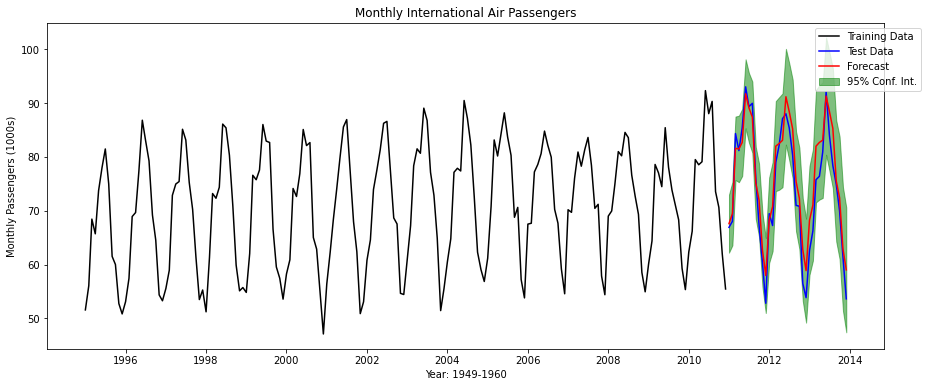

In [30]:
# Graph the training data (1949-1957).
# Add the predictions for the testing data (1958-1960).
# Add observed values from testing data.

fig, ax = plt.subplots(figsize=(15, 6))
plt.xlabel('Year: 1949-1960')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly International Air Passengers')
plt.fill_between(test.index, y_pred_lb, y_pred_ub, color='green', alpha=0.5, label='95% Conf. Int.')
plt.plot(train, color='black', label='Training Data')
plt.plot(test, color='blue', label='Test Data')
plt.plot(y_pred, color='red', label='Forecast')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

In [33]:
# Create a dataframe with the observed values for the testing dataset.
# Add the predictions from the ARIMA model.
# Add the low and high boundaries for the 95% confidence intervals.

test_pred = pd.DataFrame({
    'Actual': test.iloc[:, 0].values, 
    'Point Forecast': y_pred.values, 
    'Lo 95': y_pred_lb,
    'Hi 95': y_pred_ub
    }, index=test.index)

In [34]:
test_pred.head()

,Actual,Point Forecast,Lo 95,Hi 95
Month,,,,
2011-01-01,66.918,67.608767,62.223598,72.993937
2011-02-01,68.038,69.472896,63.594889,75.350902
2011-03-01,84.334,81.602118,75.710037,87.494198
2011-04-01,81.173,81.476787,75.303823,87.649752
2011-05-01,85.391,82.688474,76.471728,88.905221
